In [1]:
# ! pip install tensorflow
# ! pip install mlxtend 

### Introduction

### Load Libraries

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.utils import to_categorical

### Load Data

In [3]:
data = pd.read_csv('https://github.com/unclethien/Facial-Expression-Recognition/raw/main/Dataset/icml_face_data.csv')
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


### Overview

In [4]:
data[' Usage'].value_counts()

 Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

### Prepare Data

In [5]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

Define training, validation and test data:

In [6]:
# Prepare data for modeling 
# input: data frame with labels und pixel data
# output: image and label array

def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

In [7]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

Reshape and scale the image:

In [8]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

Encoding of the target value:

In [9]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

In [10]:
# Plot example image for each emotion
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

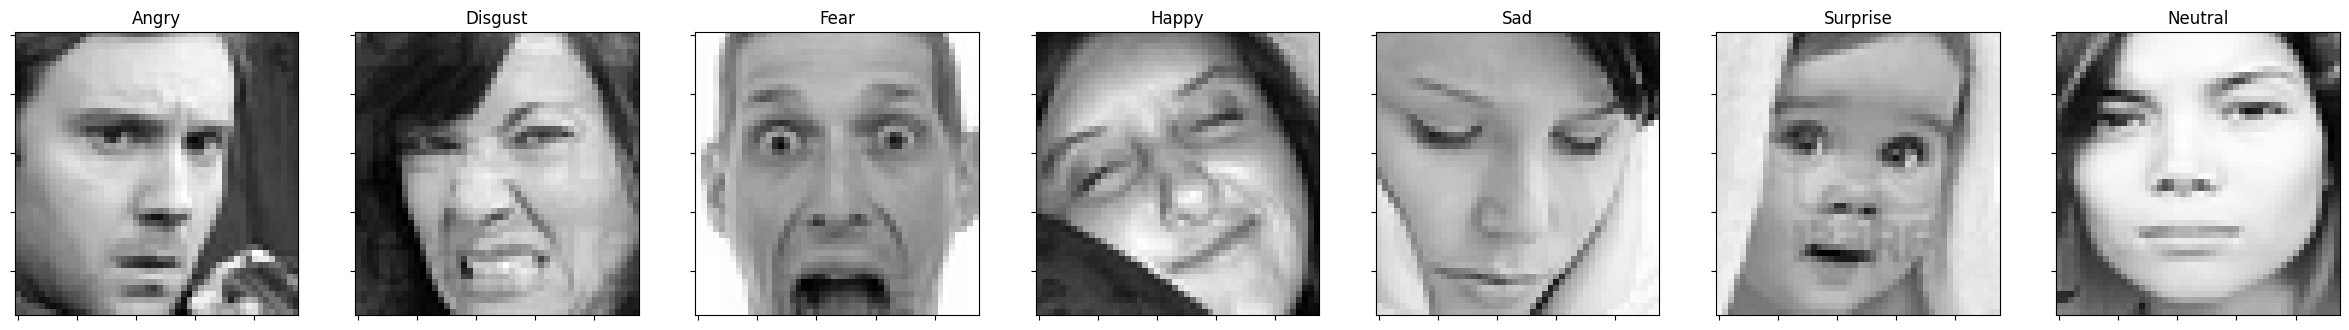

In [11]:
plot_all_emotions()

### Example Emotions

In [12]:
#Plot 5 examples of one emotion
def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

#### Angry

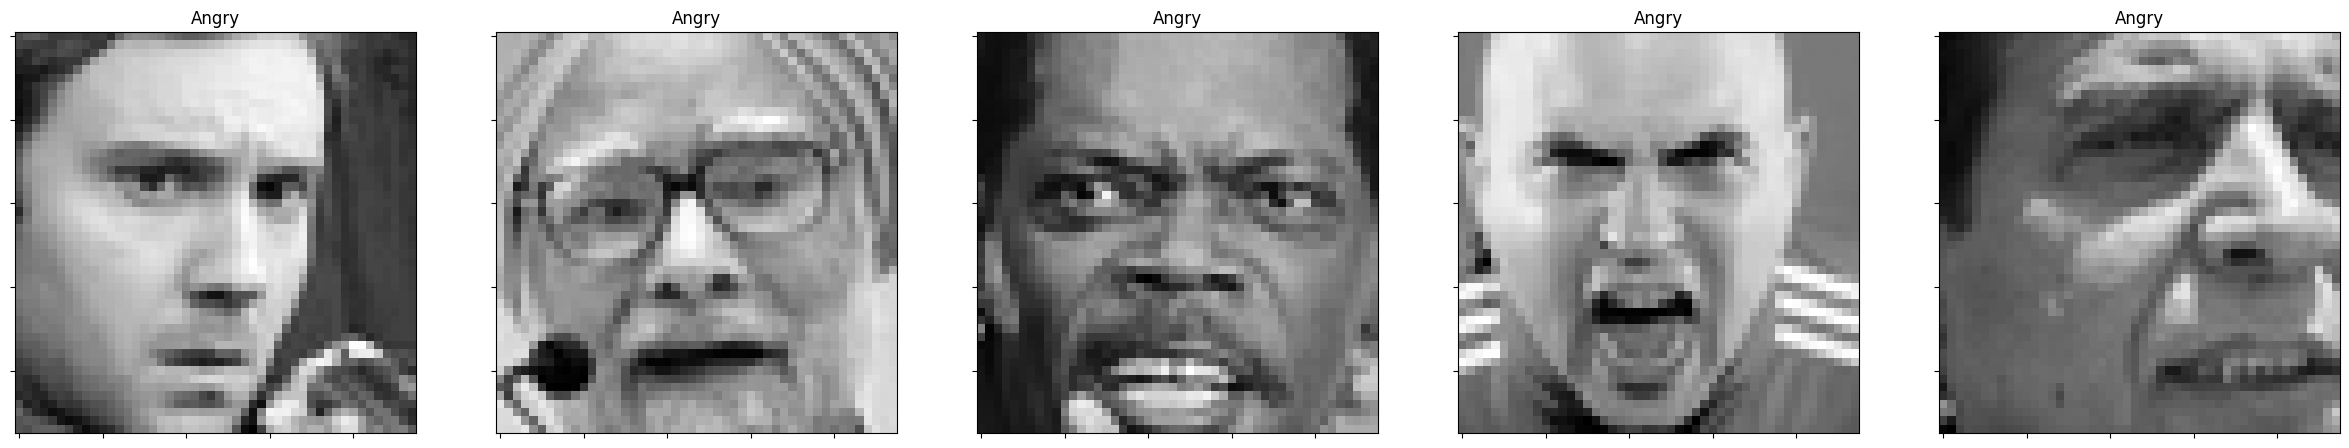

In [13]:
plot_examples(label=0)

#### Digust

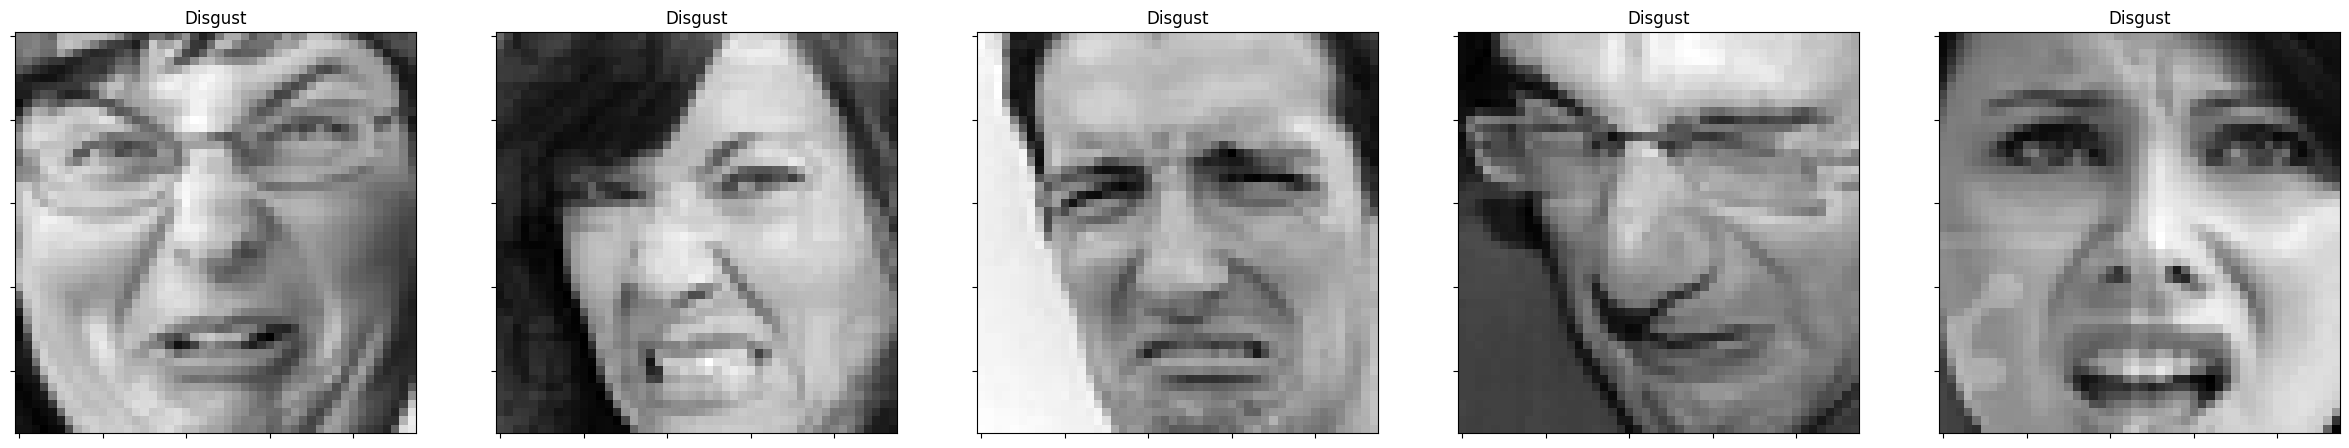

In [14]:
plot_examples(label=1)

#### Fear

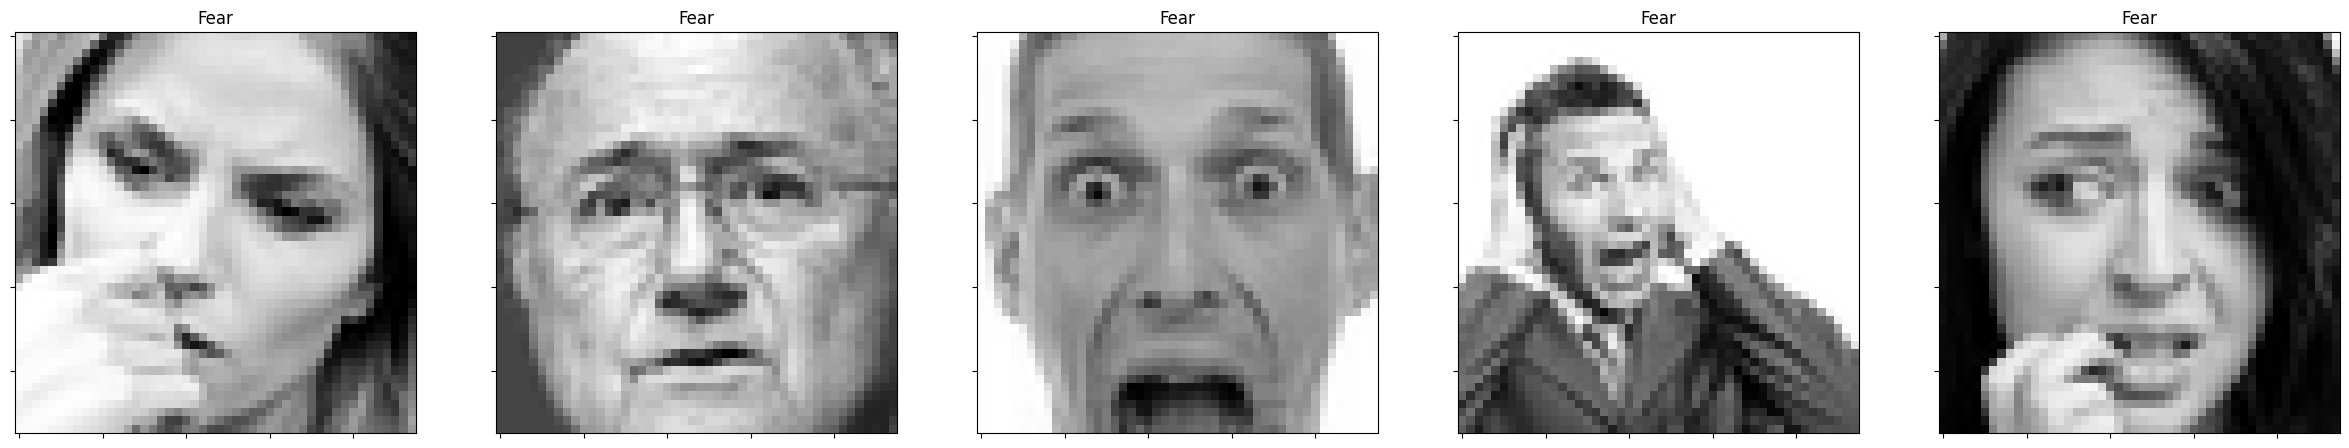

In [15]:
plot_examples(label=2)

#### Happy

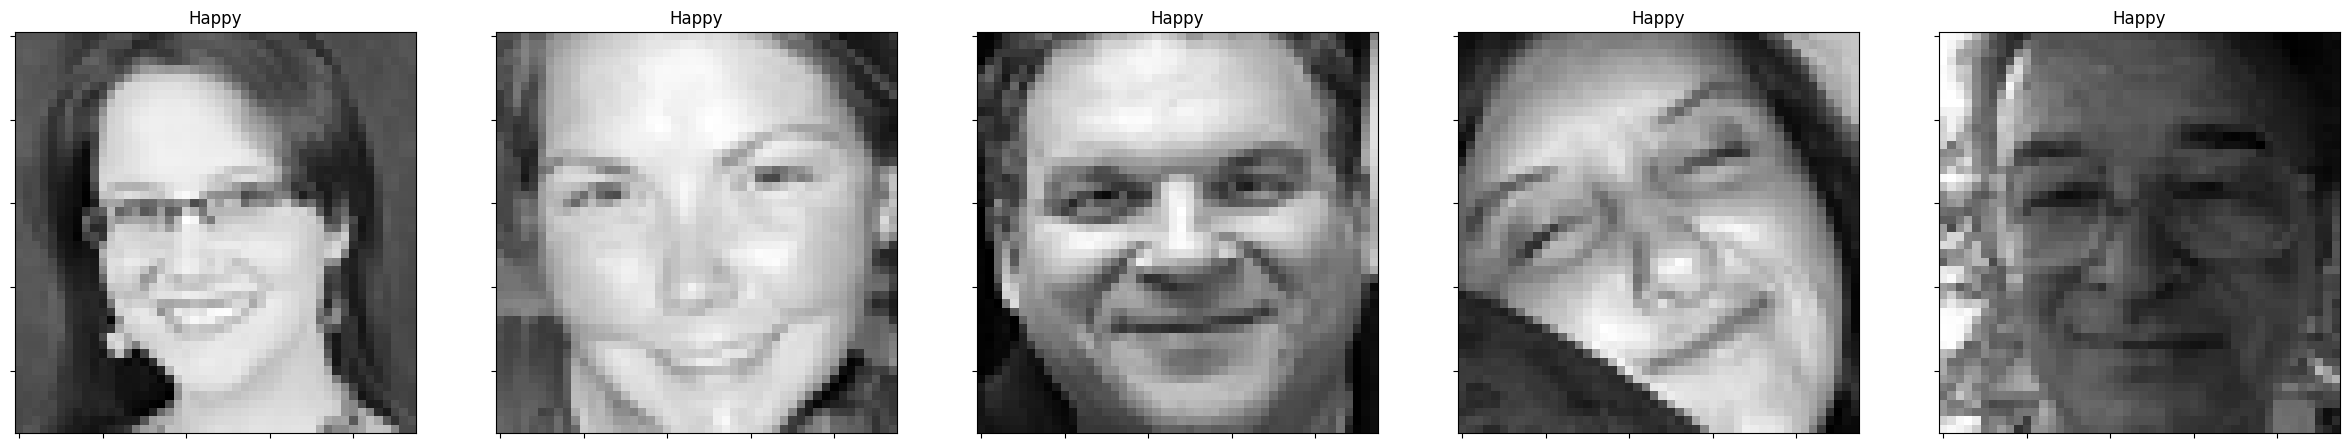

In [16]:
plot_examples(label=3)

#### Sad

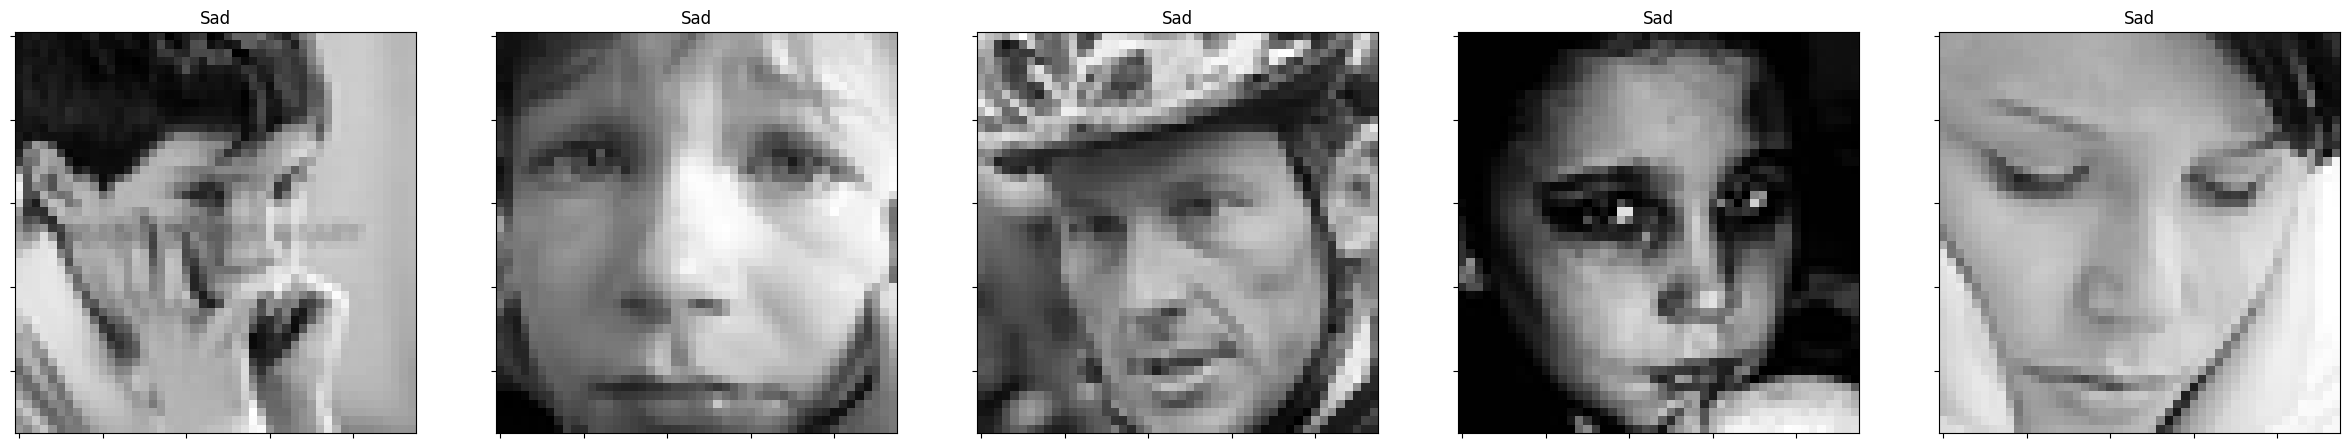

In [17]:
plot_examples(label=4)

#### Surprise

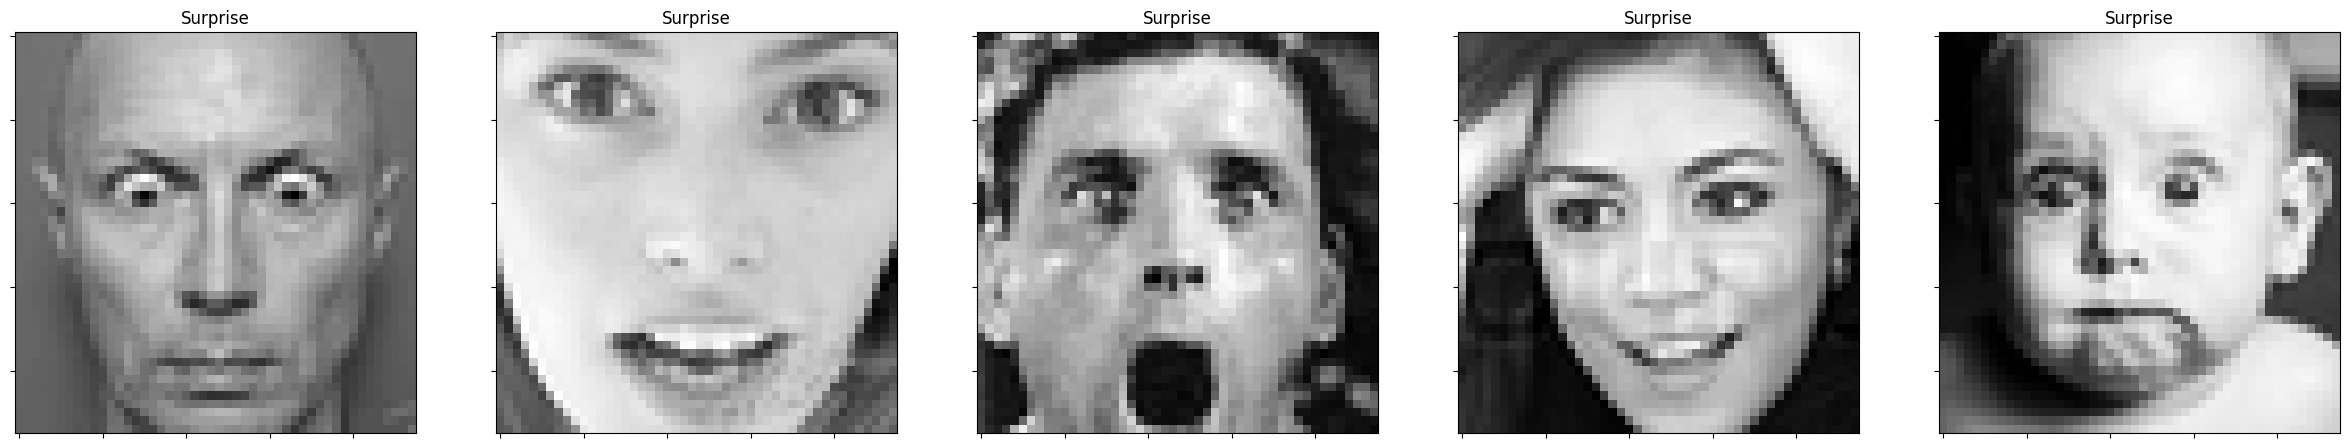

In [18]:
plot_examples(label=5)

#### Neutral

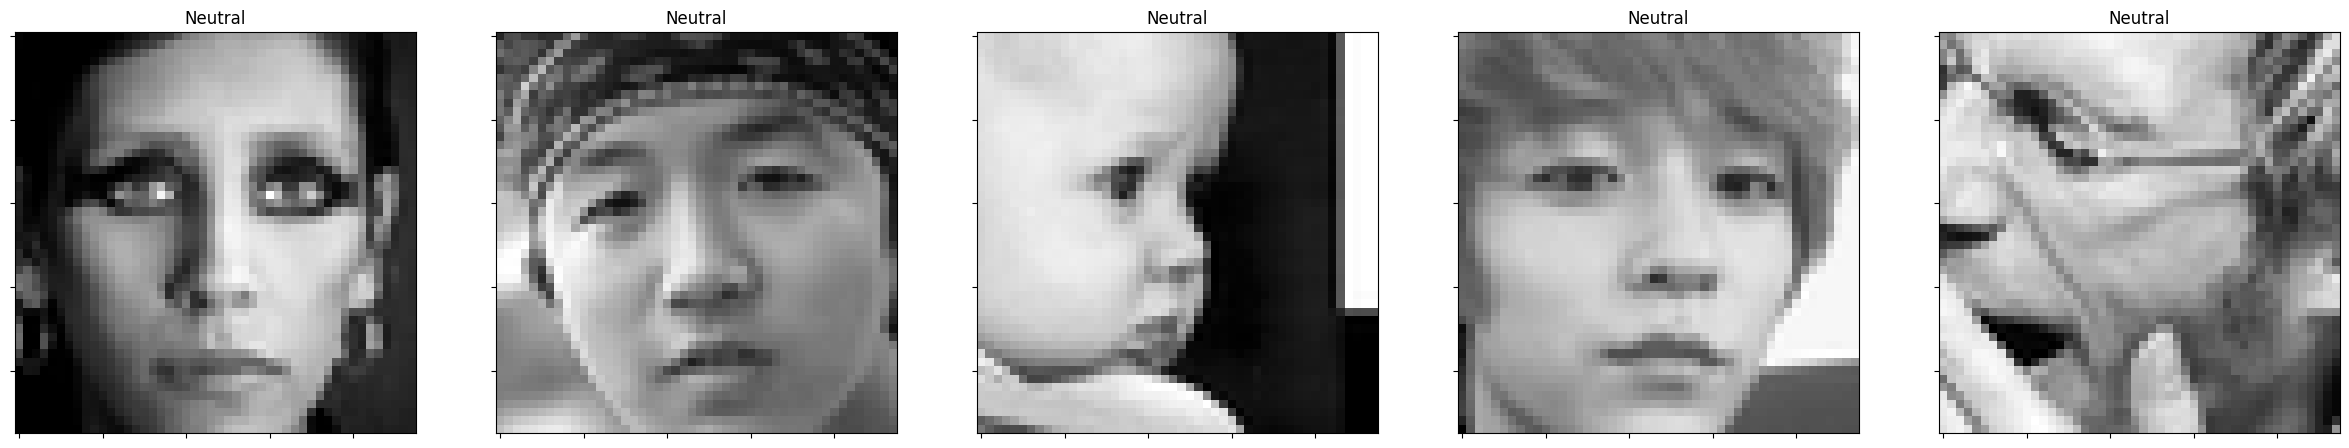

In [19]:
plot_examples(label=6)

### Distribute of labels

In [20]:
# plot compare distribution of each emotions in train, val and test data
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

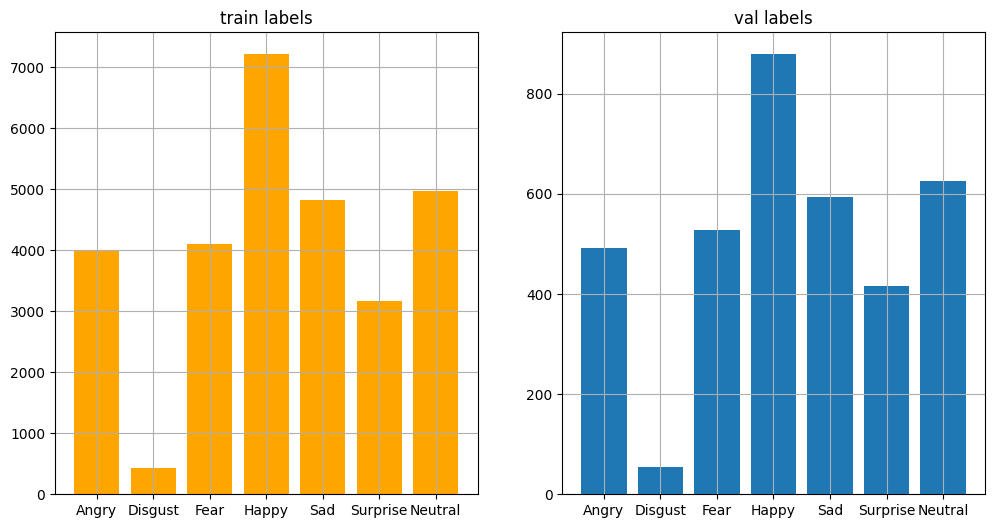

In [21]:
plot_compare_distributions(train_labels, val_labels, title1='train labels', title2='val labels')

#### Emotion Weights

In [22]:
class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))
#pie chart



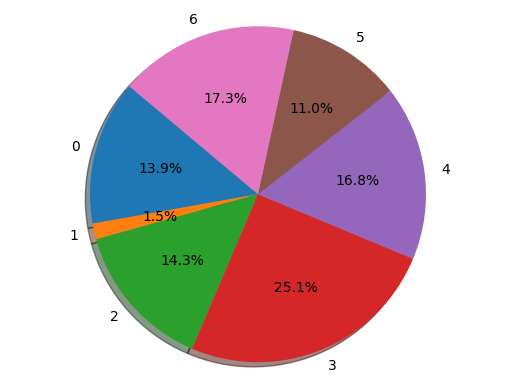

In [23]:
plt.pie(class_weight.values(), labels=class_weight.keys(), autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

### Model

In [24]:
# define CNN model
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='softmax'))


In [25]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 128)         0

In [27]:
## having early stopping and model check point 

from keras.callbacks import ModelCheckpoint, EarlyStopping

# early stopping
es = EarlyStopping(monitor='val_accuracy', min_delta= 0.01 , patience= 5, verbose= 1, mode='auto')

# model check point
mc = ModelCheckpoint(filepath="best_model.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')

# puting call back in a list 
call_back = [es, mc]

In [28]:
history = model.fit(train_images, train_labels, 
                    epochs=30, batch_size=64, 
                    class_weight=class_weight, 
                    validation_data=(val_images, val_labels),
                    callbacks=[es,mc])

Epoch 1/30


449/449 [==============================] - 28s 60ms/step - loss: 0.2609 - accuracy: 0.3379 - val_loss: 1.5195 - val_accuracy: 0.4338
Epoch 2/30
449/449 [==============================] - 27s 60ms/step - loss: 0.2197 - accuracy: 0.4545 - val_loss: 1.3858 - val_accuracy: 0.4787
Epoch 3/30
449/449 [==============================] - 27s 60ms/step - loss: 0.2003 - accuracy: 0.5066 - val_loss: 1.3287 - val_accuracy: 0.5052
Epoch 4/30
449/449 [==============================] - 27s 60ms/step - loss: 0.1871 - accuracy: 0.5407 - val_loss: 1.3110 - val_accuracy: 0.5113
Epoch 5/30
449/449 [==============================] - 27s 60ms/step - loss: 0.1756 - accuracy: 0.5667 - val_loss: 1.2173 - val_accuracy: 0.5528
Epoch 6/30
449/449 [==============================] - 27s 60ms/step - loss: 0.1665 - accuracy: 0.5886 - val_loss: 1.2586 - val_accuracy: 0.5347
Epoch 7/30
449/449 [==============================] - 27s 60ms/step - loss: 0.1575 - accuracy: 0.6097 - val_loss: 1.2165 - val_accuracy: 0.5592
Epo

KeyboardInterrupt: 

In [ ]:
pred_test_labels = model.predict(test_images)

113/113 [==============================] - 1s 8ms/step


In [ ]:
# Loading the best fit model 
from keras.models import load_model
model = load_model("/content/best_model.h5")

### Analyse Convergence

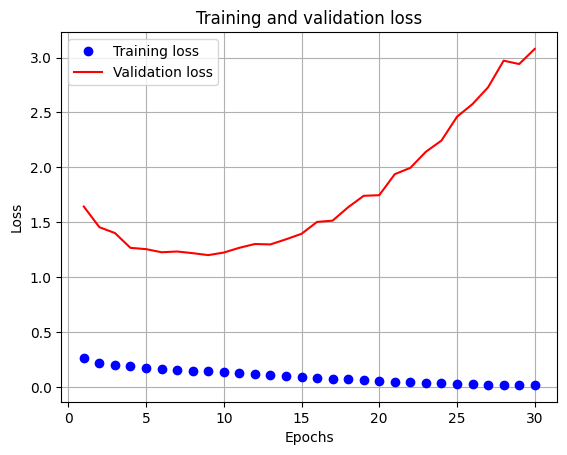

In [ ]:
#plot value of loss fuction
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()
plt.show()


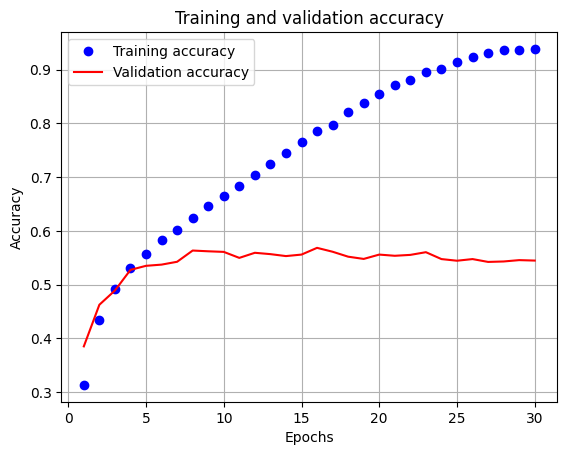

In [ ]:

#plot value of accuracy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.grid()
plt.show()


### Analyse Results

In [ ]:
# Function to plot the image and compare the prediction results with the label
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    bar_label = emotions.values()

    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])

    axs[1].bar(bar_label, pred_test_labels[image_number], color = 'orange', alpha = 0.7)
    axs[1].grid()
    plt.show()


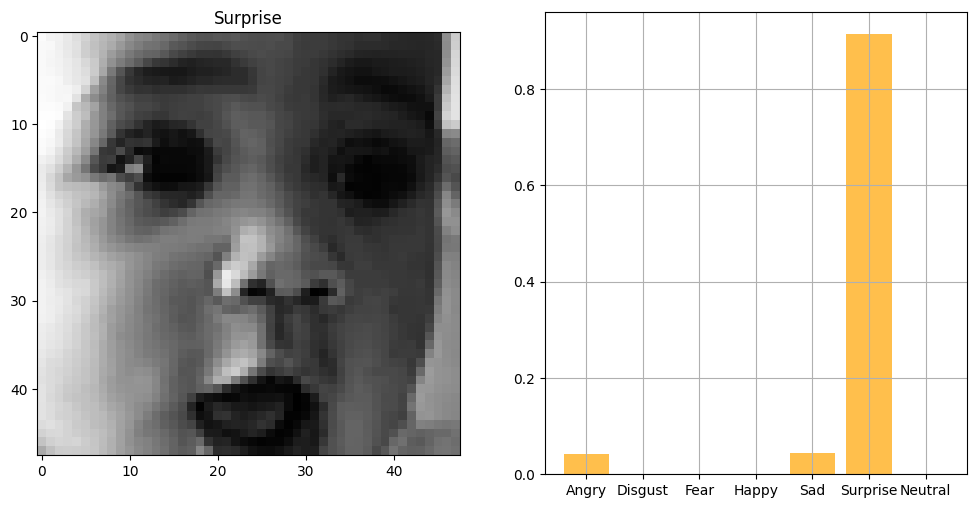

In [ ]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 154)

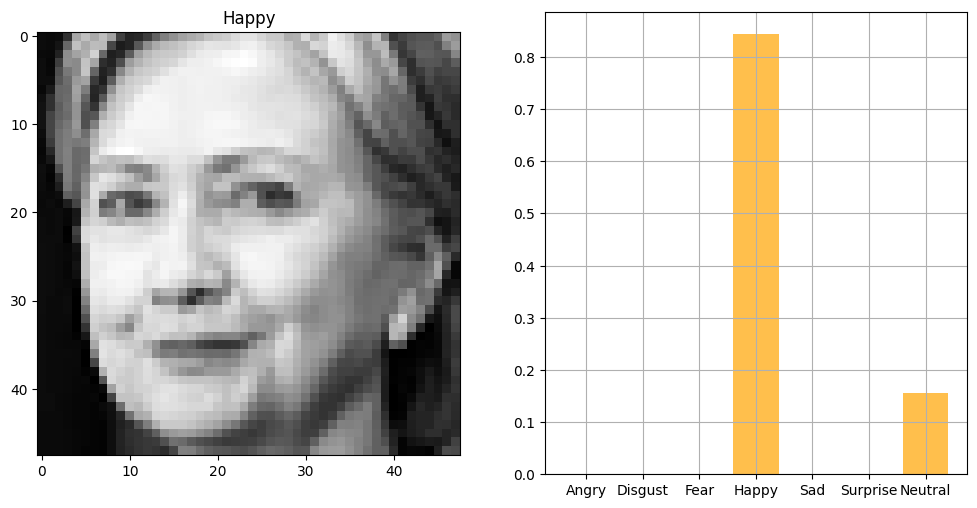

In [ ]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 247)

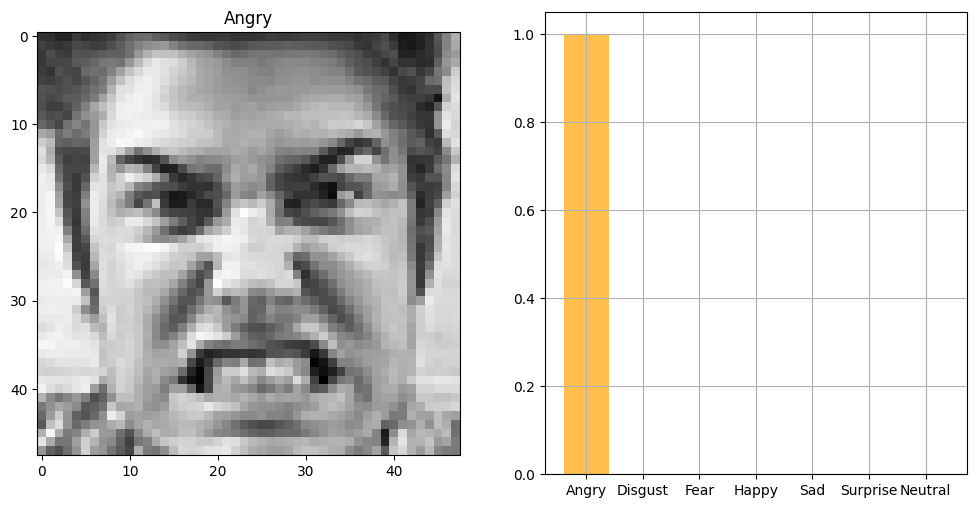

In [ ]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 40)

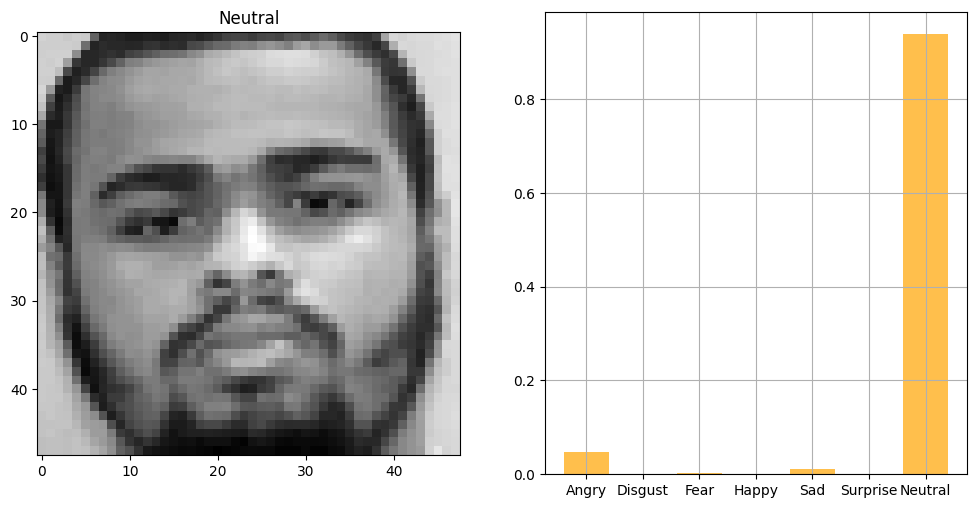

In [ ]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 106)

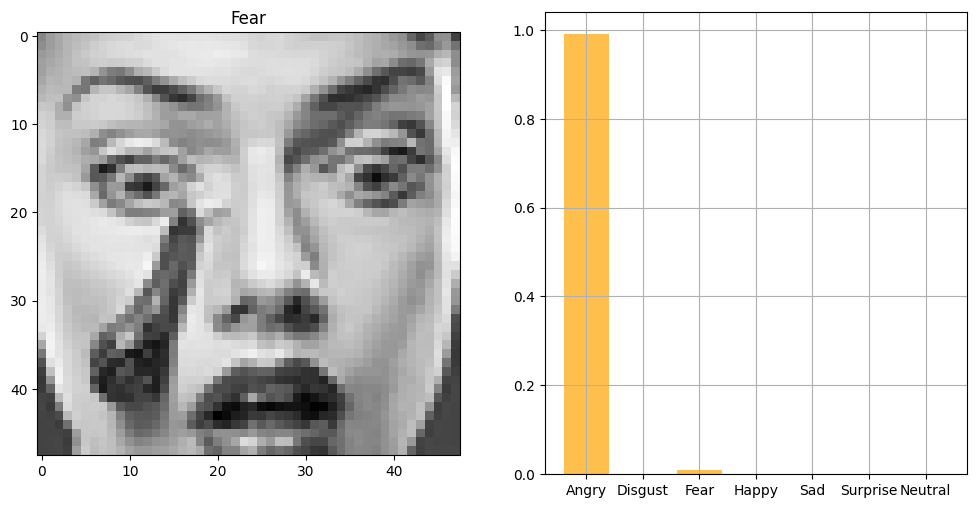

In [ ]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 15)

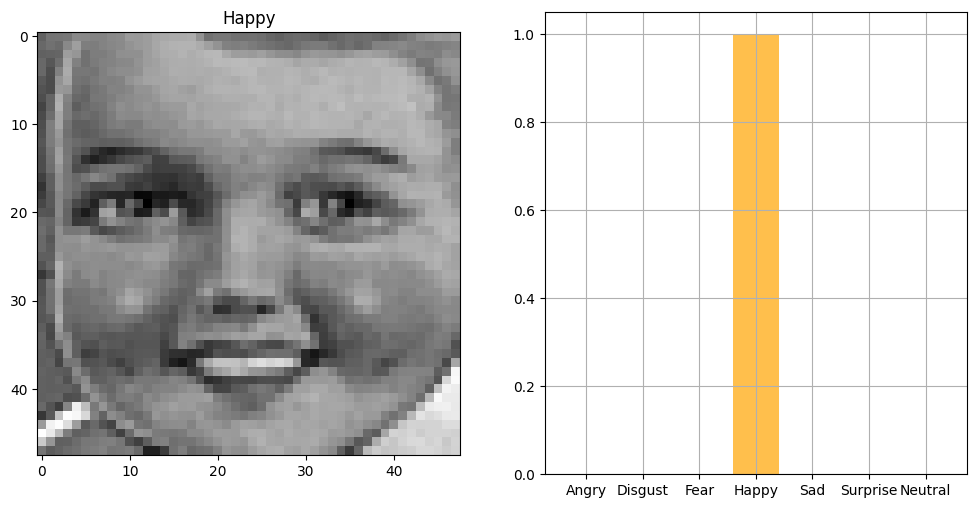

In [ ]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 30)

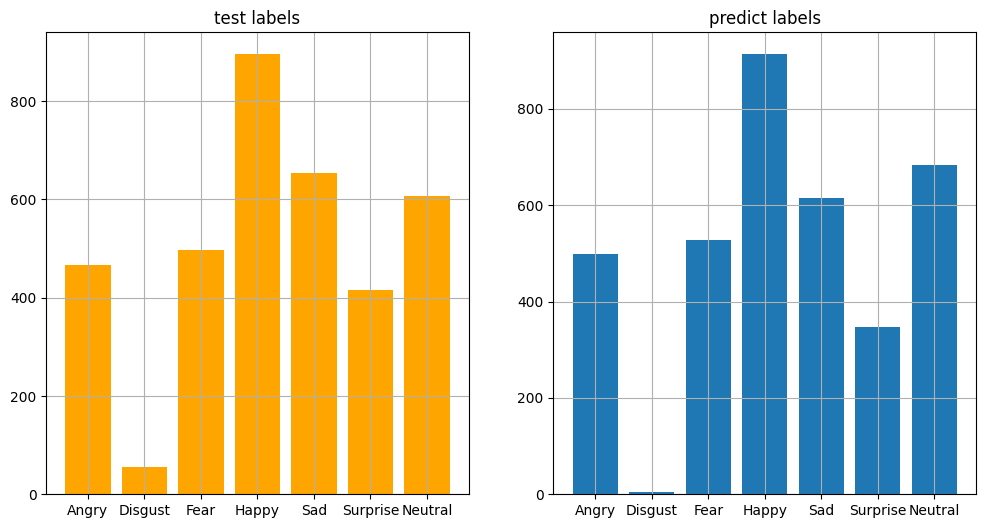

In [ ]:
# Compare distribution of predicted labels with test labels
plot_compare_distributions(test_labels, pred_test_labels, title1='test labels', title2='predict labels')

### Analyse wrong prediction

In [ ]:
df_compare = pd.DataFrame()
df_compare['test_labels'] = test_labels.argmax(axis=1)
df_compare['pred_labels'] = pred_test_labels.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['test_labels']!=df_compare['pred_labels'], 1, 0)


C:\Users\thien\AppData\Local\Temp\ipykernel_19524\2334260548.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


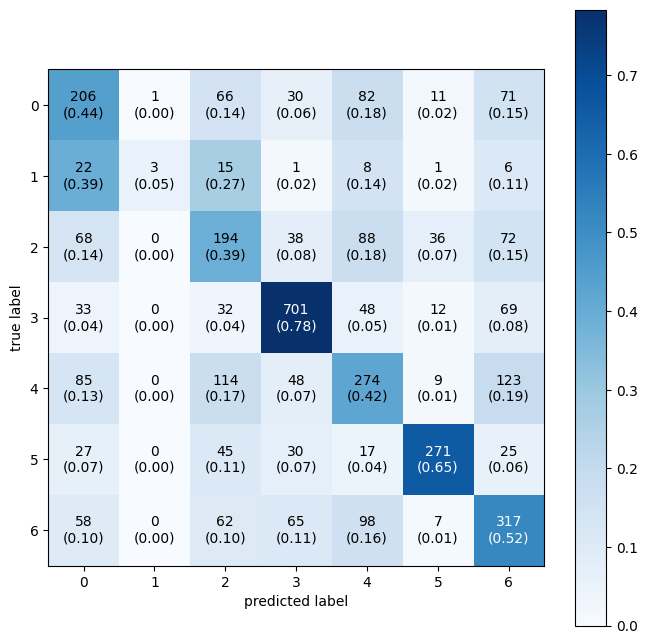

In [ ]:
conf_matrix = confusion_matrix(df_compare['test_labels'], df_compare['pred_labels'])

fig, ax = plot_confusion_matrix(conf_mat=conf_matrix,
                                show_normed=True,
                                figsize=(8,8),
                                colorbar=True)
fig.show()